In [1]:
import tensorflow.keras as keras
import tensorflow as tf
#DQN 
from Env import *

class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            print(self.length)
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

def sample_memories(batch_size, replay_memory):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return (cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1))

def epsilon_greedy_policy(state, epssilon, model):
    state=np.array(state)
    state=state.reshape(1,-1)
    if np.random.rand() < epssilon:
        #print("explore")
        return(np.random.randint(output_shape))
    else:
        #print(state.shape)
        #print("exploit")
        Q_values=model.predict(state)
        a=np.argmax(Q_values[0])
        #print ("selected action_id:")
        #print(a)
        return (np.argmax(Q_values[0]))

def play_one_step (env, state, epsilon, model,replay_memory ):
    action_id= epsilon_greedy_policy (state, epsilon, model)
    action_space=env.get_possible_action_space()
    action=action_space[action_id]
    #print(action)
    env.apply_action(action)
   
    next_state,reward=env.update_state()
    replay_memory.append((state, action_id, reward, next_state, False))
    
    return (next_state, reward)

def training_step(batch_size, discount_factor ,output_shape, model ,loss_fn, optimizer,replay_memory):
    #model.summary()
    expriences= sample_memories(batch_size,replay_memory)
    states, actions, rewards, next_states, done= expriences 
    
    #print(next_states.shape)
    
    next_Q_values= model.predict(next_states)
   
    max_next_Q_values=np.max(next_Q_values, axis=1)
    max_next_Q_values=max_next_Q_values.reshape(-1,1)
   
    
    rewards=rewards.reshape(-1,1)
    print(rewards.shape)
    target_Q_values=(rewards+ discount_factor * max_next_Q_values)
    target_Q_values=target_Q_values.reshape(-1,1)
    
    mask=tf.one_hot(actions, output_shape)
    #print("mask:")
    #print(mask)
    with tf.GradientTape() as tape:
        #print(states.shape)
        states=np.float32(states)
        all_Q_values=model(states)
        
        #print(mask.shape)
        Q_values=tf.reduce_sum(all_Q_values*mask, axis=1)
        
        
        loss=tf.reduce_mean(loss_fn(target_Q_values, Q_values))
        print("loss is " + str( float(loss)))
        grads=tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        
    


In [2]:
relay_net_slow, relay_net_fast= create_example_env()
State,Reward=relay_net_slow.update_state()
d_state=len(State)
print("State dimension: " + str(d_state))
env=relay_net_slow
Action_space=env.get_possible_action_space()
    
#print(Action_space)



input_shape=[len(State)]  #total dimension of the observation
output_shape=len(Action_space)  #action space dim

print("input/output dims of the DQN: " + str((input_shape, output_shape)))

model=keras.models.Sequential ([keras.layers.Dense( 32, name="layer1", activation ="relu" ,input_shape=(d_state,)),
    keras.layers.Dense( 32, activation ="relu",name="layer2"), 
    keras.layers.Dense( output_shape,name="layer3") ])

model.summary()




replay_memory_size = int(1e6)
replay_memory = ReplayMemory(replay_memory_size)


batch_size=32
discount_factor=0.95
optimizer=tf.keras.optimizers.Adam(lr=1e-3)
loss_fn=keras.losses.mean_squared_error

for episode in range(100):
    env,dummy= create_example_env()
    state,reward=env.update_state()       

    print("episode #" +str(episode))
    
    for step in range(1000):
        epsilon=max(1-episode/500, 0.01)
        
        #print(state)
        play_one_step (env, state, epsilon, model,replay_memory)
    if episode >5:
        training_step(batch_size, discount_factor ,output_shape, model ,loss_fn, optimizer, replay_memory)


State dimension: 20
input/output dims of the DQN: ([20], 49)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 32)                672       
_________________________________________________________________
layer2 (Dense)               (None, 32)                1056      
_________________________________________________________________
layer3 (Dense)               (None, 49)                1617      
Total params: 3,345
Trainable params: 3,345
Non-trainable params: 0
_________________________________________________________________
episode #0
episode #1
episode #2
episode #3
episode #4
episode #5
episode #6
7000
(32, 1)
loss is 4411.841796875
episode #7
8000
(32, 1)
loss is 3732.722412109375
episode #8
9000
(32, 1)
loss is 4080.35400390625
episode #9
10000
(32, 1)
loss is 4883.728515625
episode #10
11000
(32, 1)
loss is 3948.312255859375
episode #11

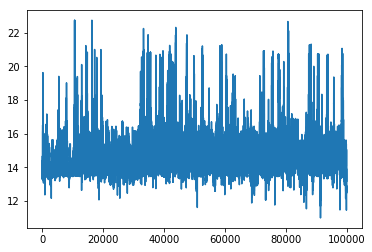

In [26]:
R=[x[2] for x in replay_memory.buf if x is not None]
plt.plot(R)
plt.show()

In [25]:
B=replay_memory.buf
print(B[100000])

None


In [8]:
!pip install --upgrade pip

ERROR: To modify pip, please run the following command:
c:\users\samgh\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
